In [30]:
# Import packages:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import math
import random

np.random.seed(0)

In [139]:
# QUESTION 1: Functions

# Full-batch GD MAP Function
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)), eta (int), epochs (int)
# OUTPUT: Return True if successful, False else
def MAPestimateGD(x_train, x_valid, x_test, y_train, y_valid, y_test, eta, epochs):
    
    # Get loss values over epochs
    losses = np.zeros(epochs)
    
    # Combine training and valiation vectors
    x_comb_0 = np.vstack((x_train, x_valid))
    x_comb_1 = np.hstack((np.ones((x_comb_0.shape[0],1)),x_comb_0))
    y_comb = np.vstack((y_train[:, 1, None], y_valid[:, 1, None]))
    y_test = y_test[:, 1, None]
    
    # Initialize weights to zero
    w = np.zeros((x_comb_1.shape[1], 1))
    
    # Train over all epochs
    for epoch in range(epochs):
        
        # Calculate summand
        summand = np.zeros((x_comb_1.shape[1], 1))
        for i in range(x_comb_1.shape[0]):
            summand += np.expand_dims(((y_comb[i] - (1 / (1 + math.exp(-(np.dot(np.transpose(w), x_comb_1[i]))))))*np.transpose(x_comb_1[i])), axis=1)

        # Update w
        w = w - eta*(w - summand)
        
        # Get loss
        loss = loss_likelihood(x_comb_1, y_comb, w)
        losses[epoch] = loss
        
        # print("GD Descent Training | Epoch: {} | Loss: {}".format(epoch, loss))
        
    # Plot the loss
    plt.plot(np.arange(epochs), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Log-Likelihood MAP Loss")
    plt.title("Full-Batch Gradient Descent Loss Over Epochs")
    plt.show()
    
    # Predict on testing data
    y_pred = np.dot(np.hstack((np.ones((x_test.shape[0],1)),x_test)), w)
    test_likelihood = -1*log_likelihood(y_test, y_pred)
    
    # Map to probability
    for i in range(y_pred.shape[0]):
        norm = (1 / (1 + math.exp(-(y_pred[i]))))
        if norm >= 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    test_acc = accuracy(y_test, y_pred)
    
    print("GD Descent Testing | Accuracy: {}% | Log Likelihood: {}".format(test_acc, test_likelihood))
    
    return True

# SGD MAP Function (batch size = 1)
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)), eta (int), epochs (int)
# OUTPUT: Return True if successful, False else
def MAPestimateSGD(x_train, x_valid, x_test, y_train, y_valid, y_test, eta, epochs):
    
    # Get loss values over epochs
    losses = np.zeros(epochs)
    
    # Combine training and valiation vectors
    x_comb_0 = np.vstack((x_train, x_valid))
    x_comb_1 = np.hstack((np.ones((x_comb_0.shape[0],1)),x_comb_0))
    y_comb = np.vstack((y_train[:, 1, None], y_valid[:, 1, None]))
    y_test = y_test[:, 1, None]
    
    # Initialize weights to zero
    w = np.zeros((x_comb_1.shape[1], 1))
    
    # Train over all epochs
    for epoch in range(epochs):
        # Get t values
        t = random.randint(0, y_comb.shape[0]-1)
        
        # Calculate summand
        summand = np.expand_dims(((y_comb[t] - (1 / (1 + math.exp(-(np.dot(np.transpose(w), x_comb_1[t]))))))*np.transpose(x_comb_1[t])), axis=1)

        # Update w
        w = w - eta*(w - summand)

        # Get loss
        loss = loss_likelihood(x_comb_1, y_comb, w)
        losses[epoch] = loss
        
        # print("SGD Descent | Epoch: {} | Loss: {}".format(epoch, loss))
        
    # Plot the loss
    plt.plot(np.arange(epochs), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Log-Likelihood MAP Loss")
    plt.title("Stochastic Gradient Descent Loss Over Epochs (Batch Size of 1)")
    plt.show()
    
    # Predict on testing data
    y_pred = np.dot(np.hstack((np.ones((x_test.shape[0],1)),x_test)), w)
    
    test_likelihood = -1*log_likelihood(y_test, y_pred)
    
    # Map to probability
    for i in range(y_pred.shape[0]):
        norm = (1 / (1 + math.exp(-(y_pred[i]))))
        if norm >= 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    test_acc = accuracy(y_test, y_pred)
    
    print("SGD Descent Testing | Accuracy: {}% | Log Likelihood: {}".format(test_acc, test_likelihood))
    
    return True

# MAP Loss Log-Likelihood Function (should be minimzed)
# INPUT: (NxD np.arrays (X), Nx1 np.arrays (Y), Dx1 np.arrays (W))
# OUTPUT: Negative log-likelihood (float)
def loss_likelihood(x, y, w):
    summand = 0
    
    for i in range(x.shape[0]):
        f_hat = (1 / (1 + math.exp(-(np.dot(np.transpose(w), x[i])))))
        summand += y[i]*np.log(f_hat) + (1-y[i])*np.log(1-f_hat)
    
    return 0.5*np.dot(np.transpose(w), w) - summand

# Log-Likelihood Function
# INPUT: (NxD np.arrays (X), Nx1 np.arrays (Y), Dx1 np.arrays (W))
# OUTPUT: Negative log-likelihood (float)
def log_likelihood(y_real,y_pred):
    summand = 0
    
    for i in range(y_real.shape[0]):
        f_hat = (1 / (1 + math.exp(-(y_pred[i]))))
        summand += y_real[i]*np.log(f_hat) + (1-y_real[i])*np.log(1-f_hat)
    
    return summand

# Accuracy Function
# INPUT: Real Y array, predicted Y array (Nx(# of classes) np.arrays)
# OUTPUT: Accuracy of results (float percentage)
def accuracy(y_real,y_pred):
    count = 0
    for line in range(y_real.shape[0]):
        if y_real[line]==y_pred[line]:
            count+=1
    return (count/(y_real.shape[0]))*100

Working with 'iris'...


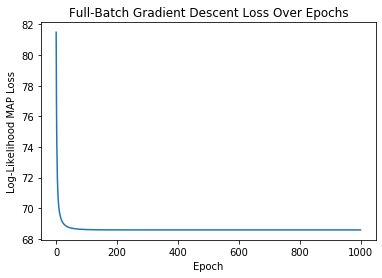

GD Descent Testing | Accuracy: 73.33333333333333% | Log Likelihood: [7.11969965]


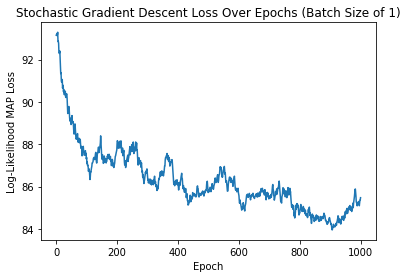

SGD Descent Testing | Accuracy: 73.33333333333333% | Log Likelihood: [9.40667308]


True

In [140]:
# QUESTION 1: Main
from data_utils import load_dataset

# 1. Uncomment the dataset you'd like to work with.

print("Working with 'iris'...")
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')

# 2. Train the logistic regression model on the iris dataset using full-batch GD
MAPestimateGD(x_train, x_valid, x_test, y_train, y_valid, y_test, 0.01, 1000)

# 3. Train the logistic regression model on the iris dataset using minibatch SGD (batch size 1)
MAPestimateSGD(x_train, x_valid, x_test, y_train, y_valid, y_test, 0.01, 1000)

In [238]:
# QUESTION 2: Functions

import autograd.numpy as np
from autograd import value_and_grad


def forward_pass(W1, W2, W3, b1, b2, b3, x):
    """
    forward-pass for an fully connected neural network with 2 hidden layers of M neurons
    Inputs:
        W1 : (M, 784) weights of first (hidden) layer
        W2 : (M, M) weights of second (hidden) layer
        W3 : (10, M) weights of third (output) layer
        b1 : (M, 1) biases of first (hidden) layer
        b2 : (M, 1) biases of second (hidden) layer
        b3 : (10, 1) biases of third (output) layer
        x : (N, 784) training inputs
    Outputs:
        Fhat : (N, 10) output of the neural network at training inputs
    """
    H1 = np.maximum(0, np.dot(x, W1.T) + b1.T) # layer 1 neurons with ReLU activation, shape (N, M)
    H2 = np.maximum(0, np.dot(H1, W2.T) + b2.T) # layer 2 neurons with ReLU activation, shape (N, M)
    Fhat = np.dot(H2, W3.T) + b3.T # layer 3 (output) neurons with linear activation, shape (N, 10)
    #################
    # QUESTION 2.a) #
    ################# 
    a = Fhat.max(axis = 1)
    Fhat = (Fhat - np.repeat(np.expand_dims((a + np.log(np.sum(np.exp(Fhat - np.repeat(np.expand_dims(a,axis=1), Fhat.shape[1], axis=1)), axis=1))),axis=1), Fhat.shape[1], axis=1))
    ###
    return Fhat


def negative_log_likelihood(W1, W2, W3, b1, b2, b3, x, y):
    """
    computes the negative log likelihood of the model `forward_pass`
    Inputs:
        W1, W2, W3, b1, b2, b3, x : same as `forward_pass`
        y : (N, 10) training responses
    Outputs:
        nll : negative log likelihood
    """
    Fhat = forward_pass(W1, W2, W3, b1, b2, b3, x)
    #################
    # QUESTION 2.b) #
    #################
    nll = -1*np.sum(Fhat*y)
    return nll
    
nll_gradients = value_and_grad(negative_log_likelihood, argnum=[0,1,2,3,4,5])
"""
    returns the output of `negative_log_likelihood` as well as the gradient of the 
    output with respect to all weights and biases
    Inputs:
        same as negative_log_likelihood (W1, W2, W3, b1, b2, b3, x, y)
    Outputs: (nll, (W1_grad, W2_grad, W3_grad, b1_grad, b2_grad, b3_grad))
        nll : output of `negative_log_likelihood`
        W1_grad : (M, 784) gradient of the nll with respect to the weights of first (hidden) layer
        W2_grad : (M, M) gradient of the nll with respect to the weights of second (hidden) layer
        W3_grad : (10, M) gradient of the nll with respect to the weights of third (output) layer
        b1_grad : (M, 1) gradient of the nll with respect to the biases of first (hidden) layer
        b2_grad : (M, 1) gradient of the nll with respect to the biases of second (hidden) layer
        b3_grad : (10, 1) gradient of the nll with respect to the biases of third (output) layer
     """
    
def update_parameters(w, grad_w, learning_rate):
    """
    perform gradient descent update to minimize an objective
    Inputs:
        w : vector of parameters
        grad_w : gradient of the loss with respect to the parameters
        learning_rate : learning rate of the optimizer
    """
    return w - learning_rate * grad_w

def train(learning_rate, epochs):
    
    # load the MNIST_small dataset
    from data_utils import load_dataset
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')
    
    # initialize the weights and biases of the network
    M = 100 # 100 neurons per hidden layer
    W1 = np.random.randn(M, 784)*(1 / np.sqrt(784)) # weights of first (hidden) layer
    W2 = np.random.randn(M, M)*(1 / np.sqrt(M)) # weights of second (hidden) layer
    W3 = np.random.randn(10, M)*(1 / np.sqrt(M)) # weights of third (output) layer
    b1 = np.zeros((M, 1)) # biases of first (hidden) layer
    b2 = np.zeros((M, 1)) # biases of second (hidden) layer
    b3 = np.zeros((10, 1)) # biases of third (output) layer
    
    loss_train = []
    loss_valid = []
    
    for i in range(epochs):
        # get range
        inds = np.arange(x_train.shape[0])
        np.random.shuffle(inds)
        inds = inds[:250]
        
        # compute the gradient
        (nll_train, (W1_grad, W2_grad, W3_grad, b1_grad, b2_grad, b3_grad)) = nll_gradients(W1, W2, W3, b1, b2, b3, x_train[inds], y_train[inds])
        nll_valid = negative_log_likelihood(W1, W2, W3, b1, b2, b3, x_valid, y_valid)
        
        # update the parameters
        W1 = update_parameters(W1, W1_grad, learning_rate)
        W2 = update_parameters(W2, W2_grad, learning_rate)
        W3 = update_parameters(W3, W3_grad, learning_rate)
        b1 = update_parameters(b1, b1_grad, learning_rate)
        b2 = update_parameters(b2, b2_grad, learning_rate)
        b3 = update_parameters(b3, b3_grad, learning_rate)
        
        # add nll values to loss arrays
        loss_train.append(nll_train)
        loss_valid.append(nll_valid)    
            
        # forward pass on the last iteration to get the accuracy
        if i == (epochs-1):
            train_pred = np.argmax(forward_pass(W1, W2, W3, b1, b2, b3, x_train), axis=1)
            train_real = np.argmax(y_train, axis=1)
            train_acc = accuracy(train_real,train_pred)
            valid_pred = np.argmax(forward_pass(W1, W2, W3, b1, b2, b3, x_valid), axis=1)
            valid_real = np.argmax(y_valid, axis=1)
            valid_acc = accuracy(valid_real,valid_pred)
            print("Training | Loss: {} | Acc: {}".format(nll_train, train_acc))
            print("Validation | Loss: {} | Acc: {}".format(nll_valid, valid_acc))
            
    # plot the loss
    plt.plot(np.arange(epochs), loss_train, label="Training Negative Log Likelihood")
    plt.plot(np.arange(epochs), loss_valid, label="Validation Negative Log Likelihood")
    plt.xlabel("Iteration")
    plt.ylabel("Negative Log-Likelihood")
    plt.title("Training and Testing Loss Trends over MNIST Dataset")
    plt.legend()
    plt.show()
    
    # test accuracy and loss
    test_pred = np.argmax(forward_pass(W1, W2, W3, b1, b2, b3, x_test), axis=1)
    test_real = np.argmax(y_test, axis=1)
    nll_test = negative_log_likelihood(W1, W2, W3, b1, b2, b3, x_test, y_test)
    test_acc = accuracy(test_real,test_pred)
    print("Test | Loss: {} | Acc: {}".format(nll_test, test_acc))
    
    """
    # uncomment to see info on the liklihood of various numbers
    guesses = 5
    min_guesses = np.ones(guesses)
    min_args = np.ones(guesses)
    min_inds = np.ones(guesses)
    from data_utils import plot_digit
    for i in range(y_test.shape[0]):
        pred = forward_pass(W1, W2, W3, b1, b2, b3, x_test[i])
        pred = (1/np.sum(pred))*(pred)
        pred = 1 - pred
        for j, saved in enumerate(min_guesses):
            if np.max(pred) < saved:
                min_guesses[j] = np.max(pred)
                min_args[j] = np.argmax(pred)
                min_inds[j] = i
                break
    for i, j in enumerate(min_inds):
        plt.title("Digit: {}, Predicted: {}".format(np.argmax(y_test[int(j)]), min_args[i]))
        plt.show(plot_digit(x_test[int(j)]))
    """

Training | Loss: 11.598187695941784 | Acc: 99.15
Validation | Loss: 174.14701100001724 | Acc: 94.19999999999999


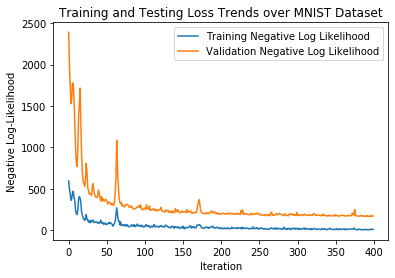

Test | Loss: 159.04542929380054 | Acc: 95.0


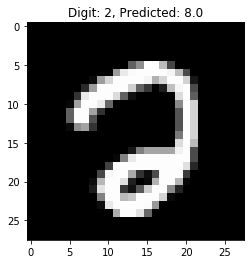

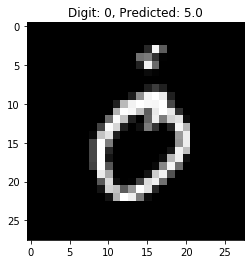

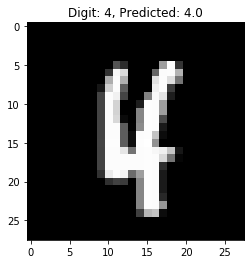

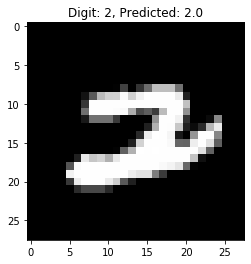

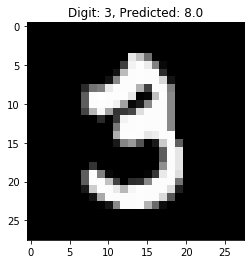

In [239]:
# QUESTION 2: Main

# 1. Train the models, plot the loss trends and get the test accuracy and loss (uncomment to train)
train(0.001, 400)
# train(0.0001, 400)
# train(0.00001, 400)